covid19cases_test.csv:
https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a?inner_span=True

insurance data (ACS_Health_Insurance_Coverage_-_County.csv):
https://covid19-uscensus.hub.arcgis.com/datasets/acs-health-insurance-coverage-county?geometry=-133.190%2C28.795%2C133.821%2C67.148

racial population data (cc-est2019-alldata-06.csv)：
https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import numpy as np
import datetime as dt

In [2]:
ca_data = pd.read_csv('data_files/covid19cases_test.csv')
ca_data = ca_data[ca_data['area_type']=='County']
ca_data.rename(columns={'area':'county'},inplace=True)
ca_data.drop('area_type',axis=1,inplace=True)
ca_cumulative = ca_data[['reported_cases','reported_deaths','county']].groupby('county').sum()
ca_cumulative['population'] = ca_data[['population','county']].groupby('county').max()

ca_cumulative['cases_rate(%)'] = ca_cumulative['reported_cases']/ca_cumulative['population']*100
ca_cumulative['deaths_rate(%)'] = ca_cumulative['reported_deaths']/ca_cumulative['population']*100
ca_cumulative.drop(['Out of state','Unknown'], axis=0, inplace=True)

In [3]:
ca_insu = pd.read_csv('data_files/ACS_Health_Insurance_Coverage_-_County.csv')
ca_insu = ca_insu[ca_insu['State']=='California']
ca_insu = ca_insu[['NAME','B27010_calc_pctNoInsE']]
ca_insu.rename(columns={'NAME':'county','B27010_calc_pctNoInsE':'Uninsured_rate(%)'},inplace=True)

def get(name):
    return name[:-7]

ca_insu['county'] = ca_insu['county'].map(get)
ca_insu.set_index('county',inplace=True)

ca_cumulative = pd.merge(left=ca_cumulative, right=ca_insu, left_on=ca_cumulative.index, right_on=ca_insu.index)
ca_cumulative.set_index('key_0',inplace=True)
ca_cumulative.sample(3)

,reported_cases,reported_deaths,population,cases_rate(%),deaths_rate(%),Uninsured_rate(%)
key_0,,,,,,
Riverside,286362.0,4398.0,2468145.0,11.602317,0.178191,8.8
Contra Costa,67029.0,782.0,1160099.0,5.777869,0.067408,5.1
Lake,3423.0,43.0,64871.0,5.276626,0.066285,7.1


/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


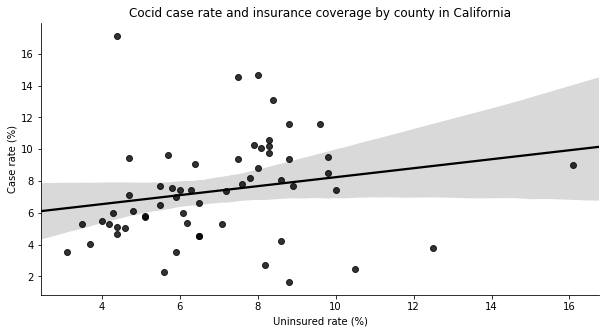

In [4]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='Uninsured_rate(%)',
            y= 'cases_rate(%)',
            data = ca_cumulative,
            ax = ax,
            color = 'Black',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid case rate and insurance coverage by county in California')
ax.set_xlabel('Uninsured rate (%)')
ax.set_ylabel('Case rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


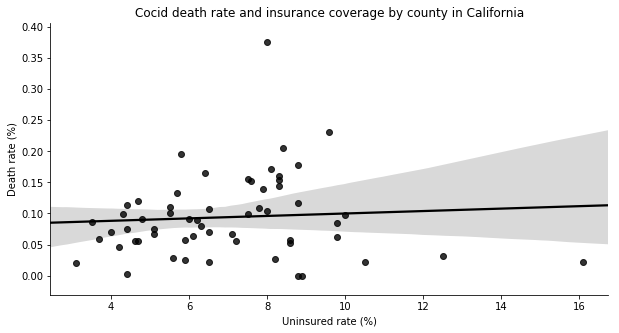

In [5]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='Uninsured_rate(%)',
            y= 'deaths_rate(%)',
            data = ca_cumulative,
            ax = ax,
            color = 'Black',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid death rate and insurance coverage by county in California')
ax.set_xlabel('Uninsured rate (%)')
ax.set_ylabel('Death rate (%)')

plt.show()

In [6]:
ca_race = pd.read_csv('data_files/cc-est2019-alldata-06.csv')
ca_race = ca_race[(ca_race['YEAR']==ca_race['YEAR'].max()) & (ca_race['AGEGRP']==0)]
ca_race.drop(['SUMLEV','STATE','COUNTY','STNAME','TOT_MALE','TOT_FEMALE','YEAR'],axis=1,inplace=True)

ca_race['white'] = ca_race['WA_MALE']+ca_race['WA_FEMALE']          # only consider white alone here
ca_race['black'] = ca_race['BA_MALE']+ca_race['BA_FEMALE']          # only consider black alone here
ca_race['hispanic'] = ca_race['H_MALE']+ca_race['H_FEMALE']          # only consider hispanic alone here
ca_race['black_hispanic'] = ca_race['black']+ca_race['hispanic']    # the number of black alone plus hispanic alone

ca_race = ca_race[['CTYNAME','TOT_POP','white','black','hispanic','black_hispanic']]
ca_race.rename(columns={'CTYNAME':'county','TOT_POP':'Population'},inplace=True)
ca_race['county'] = ca_race['county'].map(get)

ca_race = ca_race.groupby('county').sum()
ca_race['white(%)'] = ca_race['white']/ca_race['Population']*100
ca_race['black(%)'] = ca_race['black']/ca_race['Population']*100
ca_race['hispanic(%)'] = ca_race['hispanic']/ca_race['Population']*100
ca_race['black_hispanic(%)'] = ca_race['black(%)']+ca_race['hispanic(%)']

ca_race = ca_race[['white(%)','black(%)','hispanic(%)','black_hispanic(%)']]
ca_race.sample(3)

,white(%),black(%),hispanic(%),black_hispanic(%)
county,,,,
San Bernardino,76.555547,9.378258,54.438611,63.816870
Orange,71.124813,2.142557,34.042691,36.185247
Alpine,67.936227,0.354296,12.311780,12.666076


In [7]:
ca_cumulative = pd.merge(left=ca_cumulative, right=ca_race, left_on=ca_cumulative.index, right_on=ca_race.index)
ca_cumulative.set_index('key_0',inplace=True)
ca_cumulative.sample(3)

,reported_cases,reported_deaths,population,cases_rate(%),deaths_rate(%),Uninsured_rate(%),white(%),black(%),hispanic(%),black_hispanic(%)
key_0,,,,,,,,,,
Santa Clara,117457.0,1954.0,1967585.0,5.969602,0.099310,4.3,52.352411,2.833724,25.017377,27.851101
El Dorado,9773.0,106.0,193098.0,5.061161,0.054894,4.6,88.639982,1.037113,13.159928,14.197041
Amador,3633.0,46.0,38531.0,9.428772,0.119384,4.7,89.645804,2.681626,14.472228,17.153854


/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


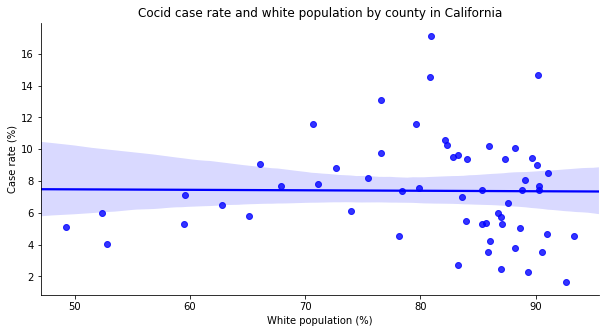

In [8]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='white(%)',
            y= 'cases_rate(%)',
            data = ca_cumulative,
            ax = ax,
            color = 'Blue',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid case rate and white population by county in California')
ax.set_xlabel('White population (%)')
ax.set_ylabel('Case rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


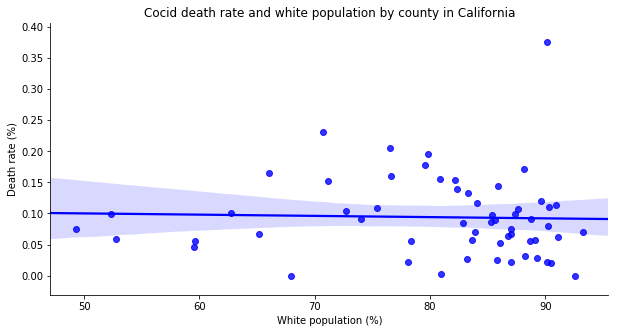

In [9]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='white(%)',
            y= 'deaths_rate(%)',
            data = ca_cumulative,
            ax = ax,
            color = 'Blue',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid death rate and white population by county in California')
ax.set_xlabel('White population (%)')
ax.set_ylabel('Death rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


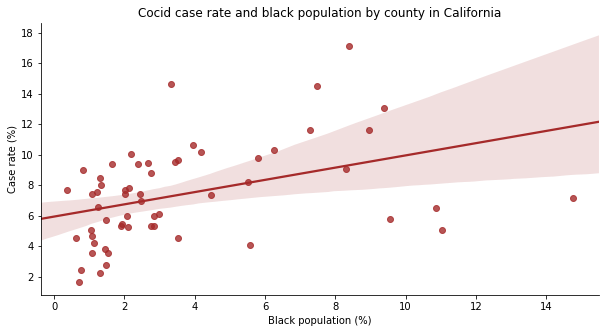

In [10]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='black(%)',
            y= 'cases_rate(%)',
            data = ca_cumulative,
            ax = ax,
            color = 'Brown',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid case rate and black population by county in California')
ax.set_xlabel('Black population (%)')
ax.set_ylabel('Case rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


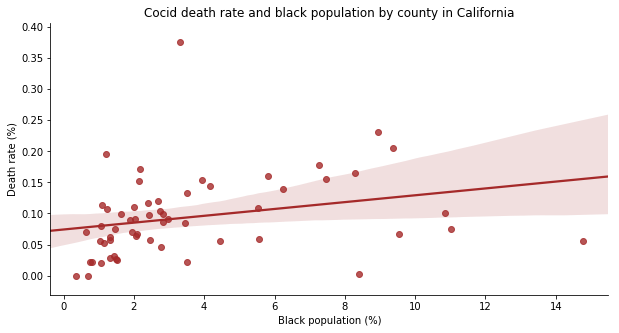

In [11]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='black(%)',
            y= 'deaths_rate(%)',
            data = ca_cumulative,
            ax = ax,
            color = 'Brown',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid death rate and black population by county in California')
ax.set_xlabel('Black population (%)')
ax.set_ylabel('Death rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


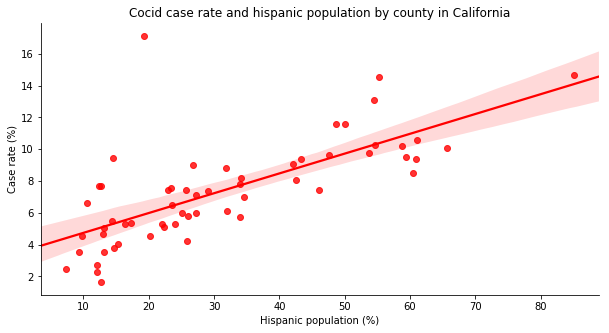

In [12]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='hispanic(%)',
            y= 'cases_rate(%)',
            data = ca_cumulative,
            ax = ax,
            color = 'Red',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid case rate and hispanic population by county in California')
ax.set_xlabel('Hispanic population (%)')
ax.set_ylabel('Case rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


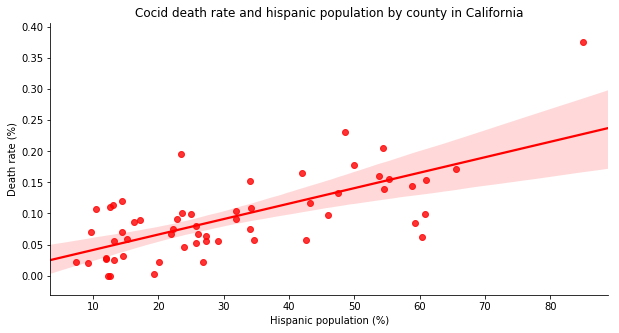

In [13]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='hispanic(%)',
            y= 'deaths_rate(%)',
            data = ca_cumulative,
            ax = ax,
            color = 'Red',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid death rate and hispanic population by county in California')
ax.set_xlabel('Hispanic population (%)')
ax.set_ylabel('Death rate (%)')

plt.show()